# pytorch手把手實作: 物件偵測模型YOLOv1實作 - 以TrafficSign為例
<br>
<font size=4> 
資料集: [kaggle的Road Sign Detection](https://www.kaggle.com/andrewmvd/road-sign-detection) <br>
<br>

我們這邊建立一個模型，但不是用Darknet19建立我們的Backbone，而是用ResNet18兜模型。<br>
細節部分可以參考我之前的文章[深度學習-物件偵測:You Only Look Once (YOLO)](https://chih-sheng-huang821.medium.com/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E7%89%A9%E4%BB%B6%E5%81%B5%E6%B8%AC-you-only-look-once-yolo-4fb9cf49453c)
    
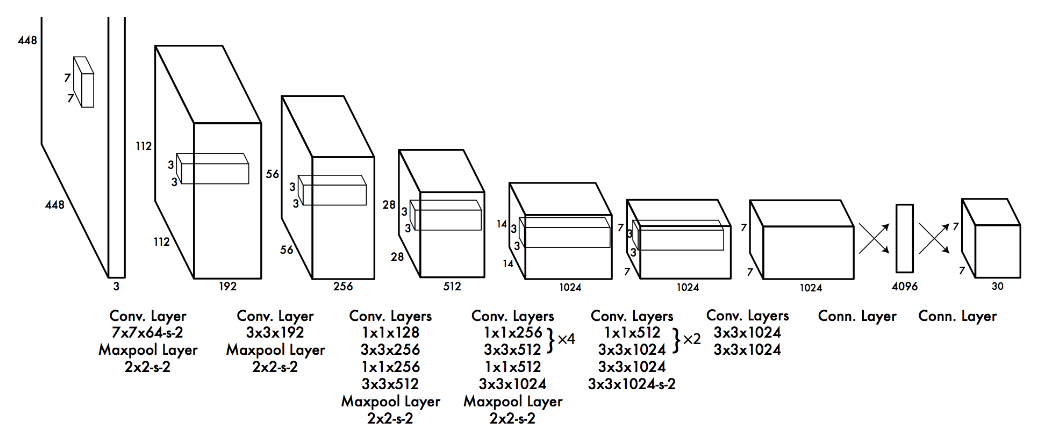


<font size = 3>
我這次設計的模型Backbone跟前一份是一樣的，採用ResNet18 <br>

但最後的全連結層和前一份資料的全連結不太一樣，然後會多加一層全連結層 <br>

然後YOLOv1最後的全連結層的輸出，會reshape成 
$$
S \times S \times(B\times5+C) 
$$
    
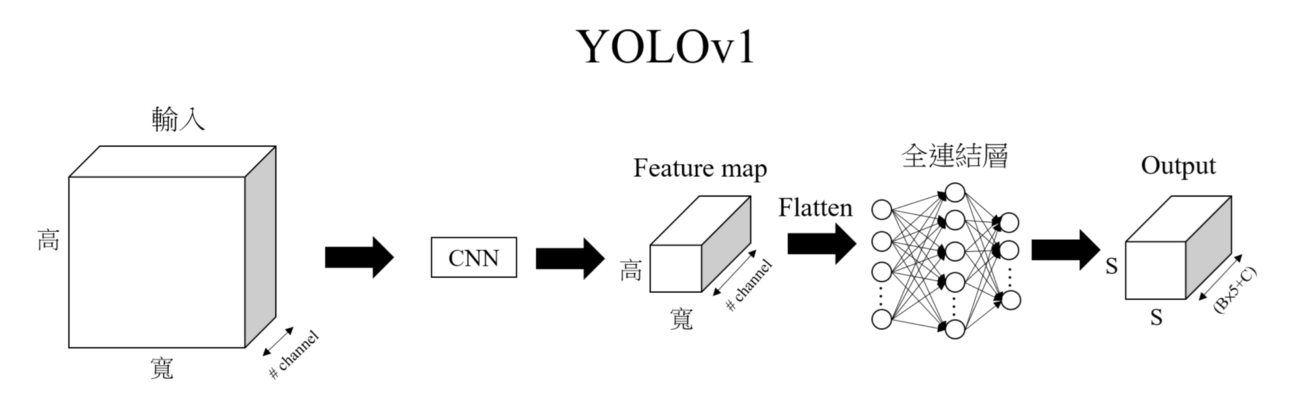

-----------------
這樣的設計可以讓每個預測框去負責預測自己區塊的物件 (location)，
$$
S \times S \times(B\times5+C) = 7 \times 7 \times(B\times5+C) 
$$
![Alt text](https://miro.medium.com/max/770/1*lxX75gUy_1kkiLerFsUcug.png)

    
每一個格子(grid)預測$B$個物件框，每個物件框帶有5個數字($B \times5$) <br>
- 分別為bounding box的中心座標(x,y)和寬長(w, h)和confidence score。
- 後面的C為隸屬於每一類別的機率。
下圖為假設($B=2$)     

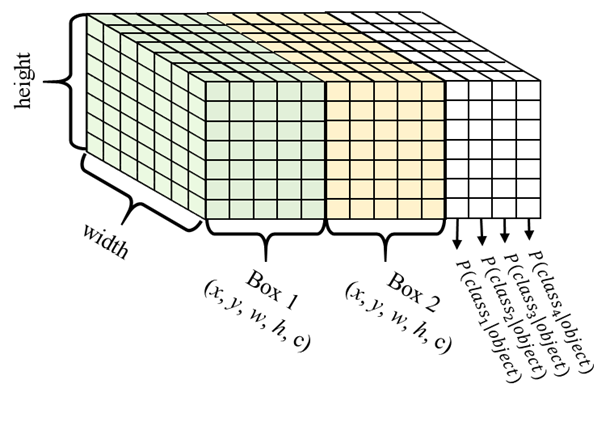
   

<font size = 3>
1. 每個grid cell的兩個BBOX的Confidence會決定這個框是不是要留下來(下圖左)<br><br>
2. 每個grid cell屬於哪個類別由上面特徵圖最後的機率決定，當每個grid cell的類別決定則可以產生類別的圖(下圖中)<br><br>
1 和 2結合決定此物件框的類別，然後再過NMS去掉多餘的框。

![Alt text](https://miro.medium.com/max/770/1*8rCJUO5MSyAmFXTg_Cumag.png)


In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import random
import math
from datetime import datetime
from collections import Counter
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

## 1. 資料庫讀取

In [2]:
# labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 4}
labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}
images_path = Path('./dataset/stopsign/images')
anno_path = Path('./dataset/stopsign/annotations')
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
def xml_parser(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels
def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations)
 

image shape:(400, 300, 3)
label:[2, 2]
bbox:[[91, 122, 141, 179], [157, 202, 172, 225]]


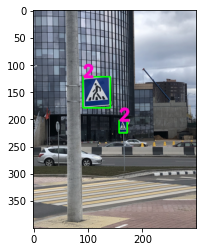

In [3]:
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()
    
data_id = 100
im = cv2.imread(str(imagepaths[data_id]))
bboxs = bboxes[data_id][1]
labels = bboxes[data_id][0]
print('image shape:{}'.format(im.shape))
print('label:{}'.format(labels))
print('bbox:{}'.format(bboxs))
plot_image_withbbox(im, bboxs, labels)

# 2. 模型架構

<br>
<font size=4> 
這邊我用RestNet18 + GAP +  Fully connection (輸出大小為一個 1D array = $S \times S \times(B\times5+C) $) <br><br> 
因為我輸入圖會限定在224x224，我採用ResNet18，因此最後輸出圖的大小被限定在7x7
所以我最後一層輸出為 $7 \times 7 \times(B\times5+ C) $
</font><br>
<br>



In [4]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

import torch

class model_yolo(nn.Module):
    # input image size = 224*224
    def __init__(self, n_class, n_bbox):
        super(model_yolo, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
#         self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, n_bbox*(n_class+1)))
        self.fc = nn.Linear(512, 512)
        self.bn = nn.BatchNorm1d(512)
        self.relu = nn.ReLU(inplace=True)
        
        self.bb = nn.Linear(512, 7 * 7 * ( n_bbox * 5 + n_class))
#         self.bb_conf = nn.Linear(512, 7 * 7 * (n_bbox*1))
#         self.bb_prob = nn.Linear(512, 7 * 7 * n_class )
#         self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # b * 3 * 224 * 224
        nbatch = x.shape[0]
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.bb(x)
        
#         x1 = self.sigmoid(x1)
#         x2 = self.bb_conf(x)
#         x2 = self.sigmoid(x2)
#         x3 = self.bb_prob(x)
#         x = torch.cat([x1,x2,x3],dim=1)
        x = x.view(nbatch,7,7,-1)
        return x

## 3. 模型訓練


### 3.1 將資料分成Train Set和Test Set</font>



In [5]:
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(20210626)
randorder = np.random.permutation(n_data)

data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

number of training data:702
number of validation data:175
number of total data:877


In [6]:
def count_object(bboxes):
    n_object=np.zeros(4)
    for boxs in bboxes:
        if len(boxs[0])>2:
            for box in boxs[0]:
                n_object[box]+=1
        else:
            n_object[boxs[0]]+=1
    print(n_object)
print('number of object in training set:')
count_object(bboxes_train)
print('number of object in validation set:')
count_object(bboxes_val)


number of object in training set:
[122. 560. 150.  71.]
number of object in validation set:
[ 34. 135.  47.  20.]


<br>

<font size=3 color='block'>**從count function可以看到**<br></font>
    
> Training set的資料分布: <br>
    >> 第0類的物件數為122個trafficlight。<br>
    >> 第1類的物件數為560個speedlimit。<br>
    >> 第2類的物件數為150個crosswalk。<br>
    >> 第3類的物件數為71個stop。<br>
    
> Validation set的資料分布: <br>
    >> 第0類的物件數為34個trafficlight。<br>
    >> 第1類的物件數為135個speedlimit。<br>
    >> 第2類的物件數為47個crosswalk。<br>
    >> 第3類的物件數為20個stop。<br>

Note: 物件對應表在前面定義在 labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}

<br>


### 3.2 開始定義Dataloader 與 data transforms


<br>
<font size=3> 
所有的圖須先轉換成固定大小<br>
這邊我們先簡單寫個函數(resizewithbbox)將圖片的大小轉換為224*224，同時將對應的BBOX也需要跟著轉換。</font>
<br>

original image


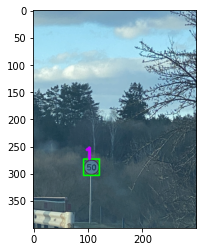

resized image


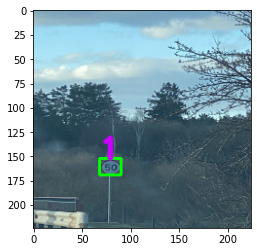

original image


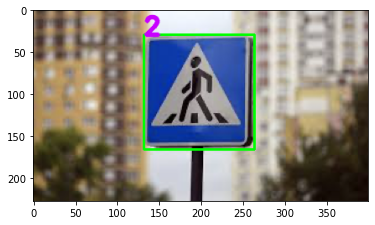

resized image


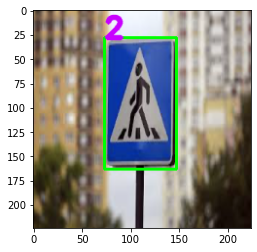

In [7]:
def resizewithbbox(image, bboxes, newsize=[224,224]):
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]*scale_w 
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_h 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_w 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_h 
    return new_image, new_bboxes

for image_id in [100,10]:    
    image_path = data_train[image_id]
    bboxes = bboxes_train[image_id][1]
    labels = bboxes_train[image_id][0]

    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxes, labels,flag_bgr=0)

    print('resized image')
    new_img, new_bboxes = resizewithbbox(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)



<br>
<font size=3> 

後續的圖片會利用torchvision的函數進行data transforms轉換 <br>
    1. 所有的圖片都需要用transforms.ToTensor，將8bits RGB PIL格式圖片(0-255)直接除上255轉換成(0-1)。<br>
    2. 利用transforms.Normalize將圖片進行正規化(Z-socre)，平均數和變異數採用ImageNet資料庫計算出來的值。<br>
    
針對訓練資料部分，將額外利用<br>
    transforms.ColorJitter(brightness=(0, 2), contrast=(
        0, 2), saturation=(0, 2), hue=(-0.3, 0.3))<br>
    進行資料擴增(data augumentation)。
</font>
<br>


original image


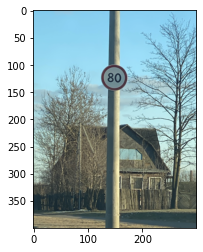

augumented image


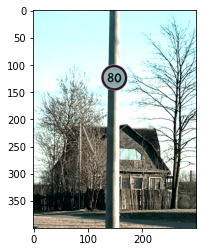

In [8]:
from torchvision import transforms
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

###### Visualization for example #######
image_id = 60    
image_path = data_train[image_id]
img = Image.open(image_path, mode='r')
img = img.convert('RGB')
img_trans = transforms_dataaug(img)
print('original image')
plt.imshow(np.array(img))
plt.show()
print('augumented image')
plt.imshow(np.array(img_trans))
plt.show()



<br>
<font size=3> 
定義Dataloader <br><br>
1. 圖片讀進來後，採用RGB格式<br><br>
2. 圖片和BBOX需要resize到正方形(原因比較好操作後續計算)，此例會將圖片resize到(224x224)<br><br>
3. 如果是training phase則需要做Data Augumentation(我用is_transforms引入)，並且以30%的機率來進行。<br><br>
4. Ground Truth的BBOX座標會被正規化到0~1: <br>所以假設resize後的座標是$(56,112)$，則模型學習的目標會轉換成$(56/224,112/224)=(0.25, 0.5)$ <br><br>
</font>


In [9]:
from torch.utils.data import Dataset, DataLoader
# imagepaths, annos, class_dict
class TrafficSignDataset(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224,224], is_transforms=False):
        self.is_transforms = is_transforms
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
        
        bboxs = bboxes[1]
        bboxs_class = bboxes[0]
        
        # 2.
        img, bboxs = resizewithbbox(img, bboxs,newsize=self.newsize)
        
        # 3.
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
        img = process_transforms(img)
        bboxs_class= torch.tensor(bboxs_class)
        
        4.
        bboxs = torch.FloatTensor(bboxs/self.newsize[0])
        
        return img, bboxs, bboxs_class
    
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        bboxes_class = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
            bboxes_class.append(b[2])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes, bboxes_class
  

### 3.3 定義 YOLOv1 Loss function</font>

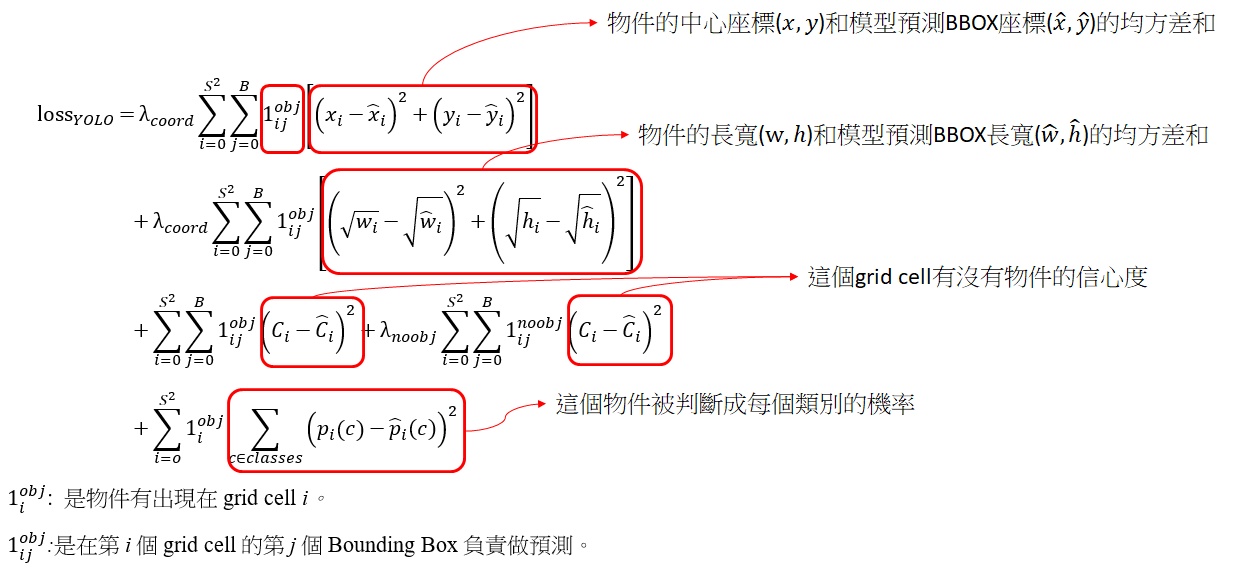


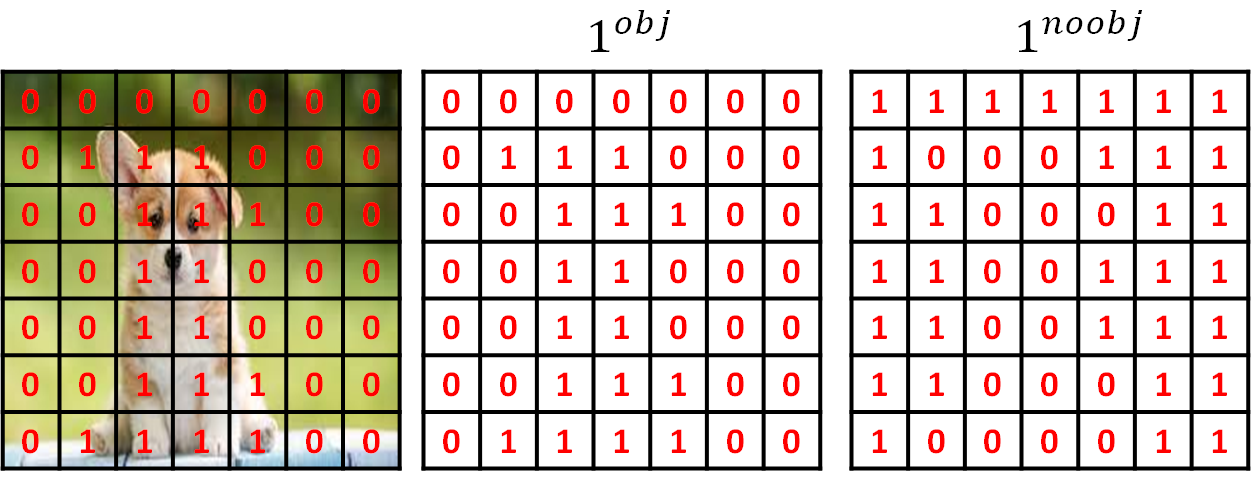

<font size=4>
    當然我們做物件偵測的label資料不是做到pixel level的標註，我們是採用長方形的框，因此在物件和非物件的判斷，應該如下:

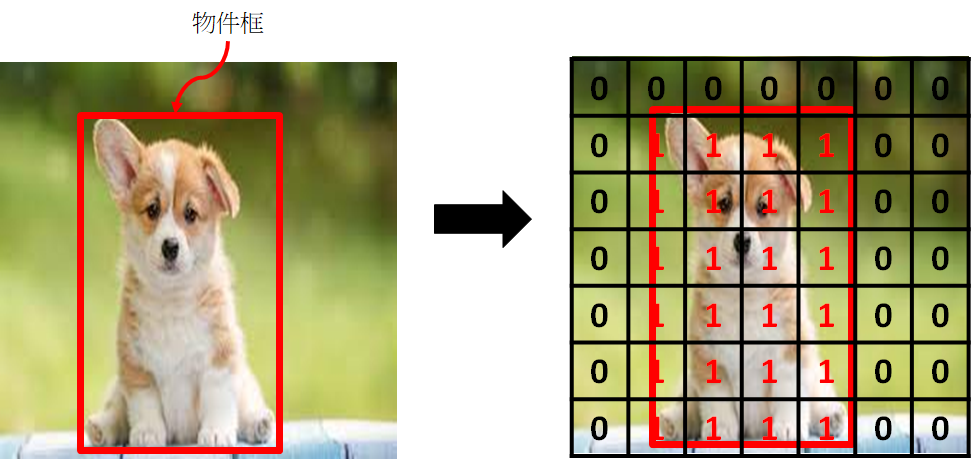

In [10]:
    
class LOSS_YOLO(nn.Module):
    def __init__(self, n_bbox, n_class, lamda_coord=5, lamda_noobj=.5):
        super(LOSS_YOLO,self).__init__()
        self.n_bbox = n_bbox
        self.n_class = n_class
        self.lamda_coord = lamda_coord #包含物件的bbox傳播損失權重
        self.lamda_noobj = lamda_noobj #不包含物件的bbox傳播損失權重
        self.softmax= nn.Softmax(dim=3) 
        self.sigmoid= nn.Sigmoid()
        
    def forward(self,preds_bb, bboxs, bboxs_class):
        # preds_bb: predict box,  n_batch * 7 * 7 * (n_bbox * 5 + n_class)
        # bboxs: ground truth, n_batch * n_object * 4
        # bboxs_class:  ground truth, n_batch * n_object 
        
        n_bbox = self.n_bbox
        n_class = self.n_class
        batch_size = preds_bb.size(0)
        w = preds_bb.size(1)
        h = preds_bb.size(2)
        
        preds_bbox, preds_conf, preds_class= self._predft2subbox(preds_bb)
#         preds_bbox: n_batch * 7 * 7 * n_bbox * 4
#         preds_conf: n_batch * 7 * 7 * n_class
#         preds_class: n_batch * 7 * 7 * n_class


        loss = 0
        for b in range(batch_size):
            #################
            ## ground truth bbox
            sub_bboxs = bboxs[b] # n_object * 4
            sub_bboxs = self._fun_box2xywh(sub_bboxs) # (x_min, ymin, x_max, y_max) -> (center_x, center_y, w, h)            
            sub_bboxs_class = bboxs_class[b] #  7 * 7 * n_class
            
            n_object = sub_bboxs.size(0)
            if n_object==0:
                continue
            gt_cxy = sub_bboxs[:,0:2] # (n_object,2)
            gt_hw = sub_bboxs[:,2:4] # (n_object,2)
            ###################
            
            ## predicted feature map
            sub_preds_class= preds_class[b,:,:,:]  # torch.Size([7, 7, n_class])
            sub_preds_conf = preds_conf[b,:,:,:]   # torch.Size([7, 7, n_bbox]) 
            sub_preds_bbox = preds_bbox[b,:,:,:,:] # torch.Size([7, 7, n_bbox, 4]) 
            
            # 1. 真實x, y 和預測的x, y的均方誤差
            pred_cxy = sub_preds_bbox[:,:,:,0:2] # # torch.Size([7, 7, n_bbox, 2])
            gt_cxy = gt_cxy.unsqueeze(0).unsqueeze(0) # (n_object,2) -> ( 1, 1, n_object, 2)
            pred_cxy = pred_cxy.unsqueeze(3) # (7,7,n_bbox,2) -> (7,7,n_bbox, 1,2)
            dif_xy = torch.pow(pred_cxy-gt_cxy,2)  # (7,7, n_bbox, n_object, 2)
            # 2. 真實w, h和預測的w, h的均方誤差
            pred_hw = sub_preds_bbox[:,:,:, 2:4] # # torch.Size([7, 7, n_bbox, 2]) 
            gt_hw = gt_hw.unsqueeze(0).unsqueeze(0).unsqueeze(0)
            pred_hw = pred_hw.unsqueeze(3)
            pred_hw = torch.sign(pred_hw) * torch.pow(torch.abs(pred_hw), 0.5)
            gt_hw = torch.sign(gt_hw) * torch.pow(torch.abs(gt_hw), 0.5)
            dif_hw = torch.pow(pred_hw-gt_hw,2)
            
            
            # loss累加宣告
            loss_box_xy, loss_box_hw, loss_p = 0,0,0            
            # 3. (1)object for confidence宣告
            gt_conf =  torch.ones((w,h,n_bbox),dtype=torch.long).to(device)*self.lamda_noobj
            # 4. confidence
            gt_conf_object =  torch.zeros((w,h,n_bbox),dtype=torch.long).to(device)
            for sub_bbox, sub_class in zip(sub_bboxs,sub_bboxs_class):
                # sub_bbox: x,y,w,h
                x_min = int(torch.ceil((sub_bbox[0]-(sub_bbox[2]/2)) * w-1))
                x_max = int(torch.ceil((sub_bbox[0]+(sub_bbox[2]/2)) * w-1))
                y_min = int(torch.ceil((sub_bbox[1]-(sub_bbox[3]/2)) * h-1))
                y_max = int(torch.ceil((sub_bbox[1]+(sub_bbox[3]/2)) * h-1)) 
                if x_min<0:x_min=0
                if y_min<0:y_min=0
                if x_max>w-1:x_max=w-1
                if y_max>h-1:y_max=h-1  
                if x_max==x_min: x_max+=1
                if y_max==y_min: y_max+=1
              
                # 4. confidence
                gt_conf[y_min:y_max,x_min:x_max,:] = 1
                gt_conf_object[y_min:y_max,x_min:x_max,:] = 1

                # 1. loss: x,y
                loss_box_xy += torch.sum(dif_xy[y_min:y_max,x_min:x_max,:,:,:])
                # 2. loss: h, y
                loss_box_hw += torch.sum(dif_hw[y_min:y_max,x_min:x_max,:,:,:])
                
                # 5. loss: class probability
                predict_label = sub_preds_class[y_min:y_max,x_min:x_max,:] # w_ob * h_ob * n_class
                w_ob, h_ob, n_class = predict_label.shape
                
                subgtlabel = torch.ones((y_max-y_min,x_max-x_min),dtype=torch.long).to(device)*sub_class
                predict_label = predict_label.reshape(w_ob*h_ob, n_class)
                
                subgtlabel = subgtlabel.reshape(w_ob*h_ob)
                loss_p += F.cross_entropy(predict_label,subgtlabel)  
   

            loss_conf =  torch.sum(gt_conf * torch.pow(sub_preds_conf-gt_conf_object, 2))                
            loss += self.lamda_coord * (loss_box_hw + loss_box_xy) + loss_conf + loss_p

        loss /= batch_size
        
        return loss
        
    def _fun_box2xywh(self, boxs):
        cenx=(boxs[:,0]+boxs[:,2])/2
        ceny=(boxs[:,1]+boxs[:,3])/2
        w=boxs[:,2]-boxs[:,0]
        h=boxs[:,3]-boxs[:,1]
        boxs[:,0]=cenx
        boxs[:,1]=ceny
        boxs[:,2]=w
        boxs[:,3]=h
        return boxs 
    
    def _predft2subbox(self, preds_bb):
        batch_size = preds_bb.size(0)
        w = preds_bb.size(1)
        h = preds_bb.size(2)
        n_bbox = self.n_bbox
        n_class = self.n_class
        preds_bbox = preds_bb[:,:,:,0:(n_bbox*5)] # n_batch * 7 * 7 * (n_bbox*5)
        preds_class = preds_bb[:,:,:,(n_bbox*5):]    # n_batch * 7 * 7 * n_class
        preds_bbox = preds_bbox.view(batch_size, w, h, n_bbox, 5) # n_batch * 7 * 7 * n_bbox * 5

        preds_conf = preds_bbox[:,:,:,:,4]    # n_batch * 7 * 7 * n_class 
        preds_bbox = preds_bbox[:,:,:,:,0:4]  # n_batch * 7 * 7 * n_bbox * 4
        
        preds_conf = self.sigmoid(preds_conf)
        preds_bbox = self.sigmoid(preds_bbox)
        preds_class = self.softmax(preds_class)    # n_batch * 7 * 7 * n_class
        return preds_bbox, preds_conf, preds_class

In [11]:
torch.cuda.empty_cache()

use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
epochs = 30
n_class = 4
n_bbox = 2
lr = 0.0002
batch_size = 16

dataset_train = TrafficSignDataset( data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
dataset_val   = TrafficSignDataset( data_val,   bboxes_val,   newsize=[224,224], is_transforms=False) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn )
valid_dl = DataLoader(dataset_val,   batch_size=batch_size, shuffle=True, collate_fn=dataset_val.collate_fn)

model = model_yolo(n_class=n_class, n_bbox=n_bbox).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

loss_od = LOSS_YOLO(n_bbox=n_bbox, n_class=n_class, lamda_coord=10, lamda_noobj=.5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [12]:
import time
loss_train_log, loss_val_log=[],[]
loss_all_train_log, loss_all_val_log=[],[]
for e in range(epochs):
    
    # training step
    model.train()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in train_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        preds_bb = model(imgs)
        
        loss = loss_od(preds_bb, bboxs, bboxs_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()
        loss_all_train_log.append(loss.item())
    time_train =  time.time()-st

    loss_train_log.append(sum_loss / total)
    
    
    # eval
    model.eval()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in valid_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        with torch.no_grad():
            preds_bb = model(imgs)
            loss = loss_od(preds_bb, bboxs, bboxs_class)
            
        total += len_batch
        sum_loss += loss.item()
        loss_all_val_log.append(loss.item())
    time_val =  (time.time()-st) 
    loss_val_log.append(sum_loss / total)
    
    print("Epoch[{}/{}], lr:{}, train_loss: {:.4f}, val_loss: {:.4f}, train_time:{:.4f},val_time:{:.4f}".format(e+1,epochs,scheduler.get_last_lr()[0], loss_train_log[-1], loss_val_log[-1],time_train,time_val))
    
    scheduler.step()
    
torch.save(model, 'YOLOv1_RestNet18.pth')
    

Epoch[1/30], lr:0.0002, train_loss: 1.7691, val_loss: 1.3211, train_time:12.9651,val_time:1.6373
Epoch[2/30], lr:0.0002, train_loss: 0.9537, val_loss: 1.0653, train_time:11.2085,val_time:1.6122
Epoch[3/30], lr:0.0002, train_loss: 0.7807, val_loss: 1.0523, train_time:11.1959,val_time:1.6073
Epoch[4/30], lr:0.0002, train_loss: 0.7064, val_loss: 0.9093, train_time:11.2739,val_time:1.6431
Epoch[5/30], lr:0.0002, train_loss: 0.6456, val_loss: 0.8598, train_time:11.2299,val_time:1.6268
Epoch[6/30], lr:0.0002, train_loss: 0.6059, val_loss: 0.8079, train_time:11.2696,val_time:1.6252
Epoch[7/30], lr:0.0002, train_loss: 0.5664, val_loss: 0.8206, train_time:11.1380,val_time:1.5912
Epoch[8/30], lr:0.0002, train_loss: 0.5536, val_loss: 0.7643, train_time:11.3263,val_time:1.6267
Epoch[9/30], lr:0.0002, train_loss: 0.5206, val_loss: 0.7918, train_time:11.2950,val_time:1.6281
Epoch[10/30], lr:0.0002, train_loss: 0.5074, val_loss: 0.7558, train_time:11.1735,val_time:1.6223
Epoch[11/30], lr:0.0001, trai

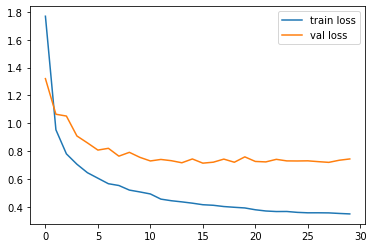

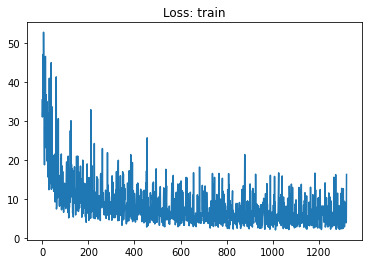

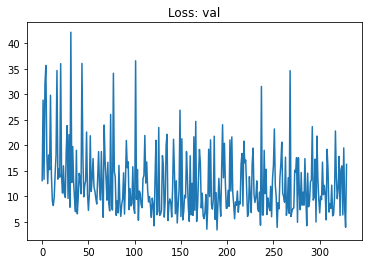

In [13]:
plt.figure()
plt.plot(loss_train_log)
plt.plot(loss_val_log)
plt.legend(['train loss','val loss'])
plt.show()

plt.figure()
plt.plot(loss_all_train_log)
plt.title('Loss: train')
plt.show()
plt.figure()
plt.plot(loss_all_val_log)
plt.title('Loss: val')
plt.show()


## 4. 模型測試

(7, 7, 2, 4)
(7, 7, 2)
(7, 7, 4)


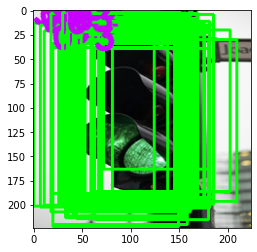

(7, 7, 2, 4)
(7, 7, 2)
(7, 7, 4)


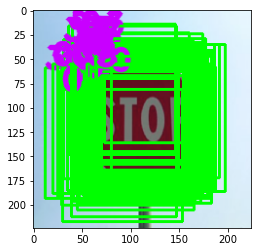

(7, 7, 2, 4)
(7, 7, 2)
(7, 7, 4)


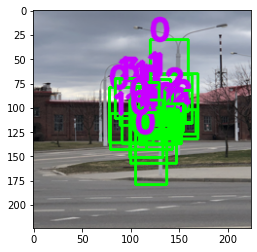

In [14]:
def pred_box2EachInf(pred_bboxs):
    pred_bbox = pred_bboxs[:,:,0:(n_bbox*5)] # 7 * 7 *40
    pred_class = pred_bboxs[:,:,(n_bbox*5):]    #  7 * 7 * n_class
    pred_bbox = pred_bbox.view(7, 7, n_bbox, 5) # 7* 7* 8*5
    pred_conf = pred_bbox[:,:,:,4]    # torch.Size([ 7, 7, 8])  
    pred_bbox = pred_bbox[:,:,:,0:4]  # torch.Size([ 7, 7, 8, 4])
    pred_class = nn.Softmax(dim=2)(pred_class)    # torch.Size([ 7, 7, 4])
    pred_conf = nn.Sigmoid()(pred_conf)
    pred_bbox = nn.Sigmoid()(pred_bbox)
    return pred_bbox, pred_conf, pred_class


def xyhw2box(canad_bbox):
    wh = canad_bbox[:,2:4] 
    xy = canad_bbox[:,0:2] 
    xy_min = xy-wh/2
    xy_max = xy+wh/2
    canad_bbox[:,0:2] = xy_min
    canad_bbox[:,2:4] = xy_max
    canad_bbox[canad_bbox<0]=0
    canad_bbox = np.array(canad_bbox, np.uint64)
                           
    return canad_bbox 

mytransforms = transforms.Compose(
            [   transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])    


image_paths =['./dataset/stopsign/images/road32.png',
              './dataset/stopsign/images/road69.png',
              './dataset/stopsign/images/road187.png']
model.eval()
for image_path in image_paths:
    image = Image.open(image_path, mode='r')
    image = image.convert('RGB')
    
    image = image.resize((224,224))  # uint8 with RGB mode
    img = mytransforms(image)
    img = torch.unsqueeze(img,dim=0)
    img = img.to(device)

    with torch.no_grad():
        preds_bb = model(img)
        
    pred_bboxs = preds_bb[0,:,:,:]
    pred_bbox, pred_conf, pred_class = pred_box2EachInf(pred_bboxs)
    pred_bbox = pred_bbox.detach().cpu().numpy()
    pred_conf = pred_conf.detach().cpu().numpy()
    pred_class = pred_class.detach().cpu().numpy()
    print(pred_bbox.shape)
    print(pred_conf.shape)
    print(pred_class.shape)
    
    pos=np.where(pred_conf>0.1)
    pred_conf = pred_conf[pos[0],pos[1],pos[2]]
    canad_bbox = pred_bbox[pos[0],pos[1],pos[2],:]*224
    canad_bbox = xyhw2box(canad_bbox)
    pred_class = pred_class[pos[0],pos[1]]          
    pred_label = np.argmax(pred_class,axis=1)
    
    image = np.array(image)
    plot_image_withbbox(image, canad_bbox, pred_label,flag_bgr=0)
    
    
    



# Inference with NMS

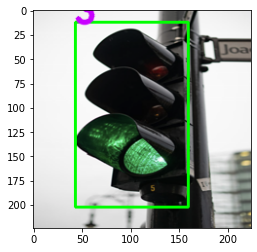

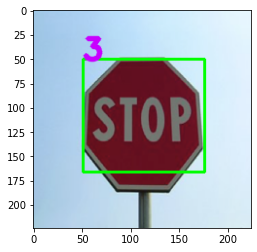

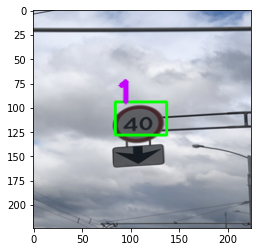

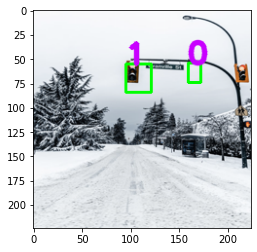

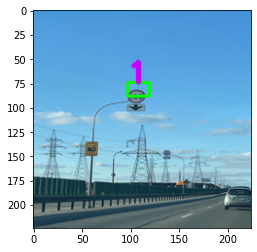

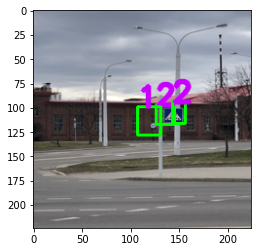

In [15]:
def nms(bboxes, scores, threshold=0.5):
    # bboxes: boundary boxes, size: n_box*4 (x_min, y_min, x_max, y_max), pytorch tensor
    # score: confidence for each box, size: n_box, pytorch tensor
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]
    areas = (x2-x1)*(y2-y1)   # [n_box,] area for each box
    _, order = scores.sort(0, descending=True)    # sort
    keep = []
    while order.numel() > 0:       # torch.numel() order裡面的物件數
        if order.numel() == 1:     #保留框只剩下一個
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0].item()    # 保留scores最大的那個物件框box[i]
            keep.append(i)
        # 计算scores最大的那個物件框box[i] 與其他物件框的IOU (boardcast運算)
        xx1 = x1[order[1:]].clamp(min=x1[i])  
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])
        inter = (xx2-xx1).clamp(min=0) * (yy2-yy1).clamp(min=0)   

        iou = inter / (areas[i]+areas[order[1:]]-inter)  
        idx = (iou <= threshold).nonzero().squeeze()
        if idx.numel() == 0:
            break
        order = order[idx+1]  
    return torch.LongTensor(keep)   

  
image_paths =['./dataset/stopsign/images/road32.png',
              './dataset/stopsign/images/road69.png',
              './dataset/stopsign/images/road201.png',
             './dataset/stopsign/images/road12.png',
             './dataset/stopsign/images/road409.png',
             './dataset/stopsign/images/road187.png']


model.eval()
for image_path in image_paths:
    image = Image.open(image_path, mode='r')
    image = image.convert('RGB')
    
    image = image.resize((224,224))  # uint8 with RGB mode
    img = mytransforms(image)
    img = torch.unsqueeze(img,dim=0)
    img = img.to(device)

    with torch.no_grad():
        preds_bb = model(img)
        
    pred_bboxs = preds_bb[0,:,:,:]
    pred_bbox, pred_conf, pred_class = pred_box2EachInf(pred_bboxs)
    pred_bbox = pred_bbox.detach().cpu().numpy()
    pred_conf = pred_conf.detach().cpu().numpy()
    pred_class = pred_class.detach().cpu().numpy()
#     print(pred_class)
#     print(np.argmax(pred_class,axis=2))
    
    pos=np.where(pred_conf>0.25)
    pred_conf = pred_conf[pos[0],pos[1],pos[2]]
    canad_bbox=pred_bbox[pos[0],pos[1],pos[2],:]*224
    canad_bbox = xyhw2box(canad_bbox)
    pred_class=pred_class[pos[0],pos[1]]          
    pred_label=np.argmax(pred_class,axis=1)
    
    pos_nms = nms(torch.FloatTensor(canad_bbox*1.0), torch.tensor(pred_conf), threshold=0.2)
    canad_bbox = canad_bbox[pos_nms.numpy(),:]
    pred_label = pred_label[pos_nms.numpy()]
    image = np.array(image)
    plot_image_withbbox(image, canad_bbox, pred_label, flag_bgr=0)
    
    
#     labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}


<font size=3>
我實際上訓練資料只有7百多張，而且也沒有好的pre-trained weight，所以這樣的偵測結果算還OK <br>
如果要偵測的更好，要再做調整，但須要再花時間，有興趣的人可以在自己試看看唷。
    
>YOLOv1 (跟SSD同期)算是第一個可以end-to-end然後在筆電上可以real-time implementation的物件偵測算法<br>  
**YOLO作者(Joseph Redmon)在TED演講(五分多鐘)**   
   

    
<a href="https://www.ted.com/talks/joseph_redmon_how_computers_learn_to_recognize_objects_instantly?language=zh-tw" target="_blank"><img src="https://cdn.hopenglish.com/wp/wp-content/uploads/2017/09/how-computers-learn-to-recognize-objects-instantly.jpg" 
width="540" border="10" /></a>
    

<font size=3>
    
YOLOv1還是有問題存在 <br>
    
1. 全連結層其實很佔運算資源。
2. 小物件偵測效果沒有很好。 
3. 如果兩個不同類別的物件靠太近，因為算法的限制有可能偵測不出來。 

YOLOv2之後的YOLO系列和SSD一樣引入Anchor，然後可以直接一路捲積到最後predict層。<br>
下一堂課介紹和手刻將實作介紹YOLOv2-v3<br>
    
</font>